In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setting random seed to make results consistent (super important!)
np.random.seed(42)

# --- Setup Stuff ---
# Change this to True if I want to use ALL the data (warning: takes forever)
# False means a quick test with a small part of the data
USE_FULL_DATA = True
CHUNK_SIZE = 100000  # How many rows to read from the CSV at once

# --- Kaggle Login ---
from google.colab import files

print("Please upload your kaggle.json file when prompted...")
uploaded = files.upload()

# Moving the uploaded file where it needs to be
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Changing file permissions for security (Kaggle said so)
!chmod 600 ~/.kaggle/kaggle.json

print("Credentials loaded. Ready to download data.")

Please upload your kaggle.json file when prompted...


Saving kaggle.json to kaggle (1).json
Credentials loaded. Ready to download data.


In [52]:
# Download the dataset if it's not here yet
if not os.path.exists('Books_rating.csv'):
    print("Downloading dataset...")
    !kaggle datasets download -d mohamedbakhet/amazon-books-reviews
    !unzip amazon-books-reviews.zip

print("Processing data in chunks to aggregate Book statistics...")

# This will hold info about each book.
# Key: Book Title, Value: [Total_Rating, How_Many_Reviews, Total_Price, How_Many_Prices]
book_stats = {}

# Only need these columns for my features
cols_to_use = ['Title', 'Price', 'review/score']

try:
    # Read the huge CSV file piece by piece
    for i, chunk in enumerate(pd.read_csv('Books_rating.csv', usecols=cols_to_use, chunksize=CHUNK_SIZE)):

        # Cleaning up the price column (getting rid of missing values)
        chunk['Price'] = pd.to_numeric(chunk['Price'], errors='coerce')

        # Grouping by book title in this chunk
        grouped = chunk.groupby('Title')

        for title, data in grouped:
            ratings_sum = data['review/score'].sum()
            count = len(data)

            # Dealing with price (could be missing sometimes)
            valid_prices = data['Price'].dropna()
            price_sum = valid_prices.sum()
            price_count = len(valid_prices)

            if title not in book_stats:
                book_stats[title] = [ratings_sum, count, price_sum, price_count]
            else:
                # Update stats if the book already exists (like adding more reviews)
                book_stats[title][0] += ratings_sum
                book_stats[title][1] += count
                book_stats[title][2] += price_sum
                book_stats[title][3] += price_count

        if not USE_FULL_DATA and i == 5:
            print("Stopping early (Subsampling mode)...")
            break

        if i % 10 == 0:
            print(f"Processed chunk {i}...")

    print("Aggregation complete.")

except Exception as e:
    print(f"Error reading data: {e}")

Processing data in chunks to aggregate Book statistics...
Processed chunk 0...
Processed chunk 10...
Processed chunk 20...
Aggregation complete.


In [53]:
# Turning my book stats into a proper table (DataFrame)
data_list = []
for title, stats in book_stats.items():
    avg_rating = stats[0] / stats[1] if stats[1] > 0 else 0
    # Calculating average price, or NaN if no price data for the book
    avg_price = stats[2] / stats[3] if stats[3] > 0 else np.nan
    review_count = stats[1]

    data_list.append([title, avg_price, avg_rating, review_count])

df_books = pd.DataFrame(data_list, columns=['Title', 'Price', 'Avg_Rating', 'Review_Count'])

# Getting rid of books that don't have a price (to make things easier for now)
df_clean = df_books.dropna().copy()

print(f"Total books after cleaning: {len(df_clean)}")

# --- Scaling Data (Z-Score) ---
# Super important for algorithms that measure distance like Euclidean
feature_cols = ['Price', 'Avg_Rating', 'Review_Count']
stats_summary = {} # Saving mean/std so I can convert back if needed

for col in feature_cols:
    mu = df_clean[col].mean()
    sigma = df_clean[col].std()
    stats_summary[col] = {'mean': mu, 'std': sigma}

    # Applying the Z-score formula: (value - mean) / standard deviation
    df_clean[col] = (df_clean[col] - mu) / sigma

# Converting to a NumPy array for the clustering algorithm
X = df_clean[feature_cols].values
titles = df_clean['Title'].values

print("Data normalized and ready.")
print(df_clean.head())

Total books after cleaning: 48418
Data normalized and ready.
                                                Title     Price  Avg_Rating  \
4   "In the Days of Serfdom" and Other Stories (Pi... -0.243215   -0.309211   
5                                "Our Brown-Eyed Boy" -0.381597   -1.014821   
7   'Pataphysics: The Poetics of an Imaginary Scie... -0.341225   -3.907819   
8          'night, Mother: A Play (Mermaid Dramabook) -0.493572    0.650417   
15  1,999 Facts About Blacks: A Sourcebook of Afri... -0.268606    0.890325   

    Review_Count  
4      -0.121437  
5       0.065888  
7      -0.121437  
8       0.101012  
15     -0.086314  


In [54]:
class ClusterSummary:
    """
    Represents a cluster using the sufficient statistics: N, SUM, SUMSQ.
    """
    def __init__(self, d):
        self.N = 0
        self.SUM = np.zeros(d)
        self.SUMSQ = np.zeros(d)
        self.centroid = np.zeros(d)
        self.std_dev = np.ones(d) # Start with 1.0 since data is Z-normalized

    def add_point(self, point):
        self.N += 1
        self.SUM += point
        self.SUMSQ += point ** 2
        self._update_stats()

    def add_points(self, points):
        self.N += len(points)
        self.SUM += np.sum(points, axis=0)
        self.SUMSQ += np.sum(points ** 2, axis=0)
        self._update_stats()

    def merge(self, other_summary):
        self.N += other_summary.N
        self.SUM += other_summary.SUM
        self.SUMSQ += other_summary.SUMSQ
        self._update_stats()

    def _update_stats(self):
        if self.N == 0: return
        self.centroid = self.SUM / self.N

        # Variance = (SUMSQ/N) - (mean^2)
        variance = (self.SUMSQ / self.N) - (self.centroid ** 2)

        # --- IMPORTANT FIX: Variance Issue ---
        # If there aren't many points, the variance calculation can be weird (often zero).
        # So, I'm using a mix with the overall variance (which is 1.0 because of the scaling).
        # This helps the cluster start off better and attract points.
        if self.N < 10:
            # Making sure std_dev starts near 1.0
            self.std_dev = np.ones_like(variance)
        else:
            # Making sure variance isn't negative (computer math quirks) and not exactly zero
            variance[variance < 1e-6] = 1e-6
            self.std_dev = np.sqrt(variance)

class BFR_Clustering:
    def __init__(self, k, dim, mahalanobis_threshold=3.0):
        self.k = k
        self.dim = dim
        self.threshold = mahalanobis_threshold

        # Sets
        self.discard_set = [ClusterSummary(dim) for _ in range(k)]
        self.compressed_set = []
        self.retained_set = []

    def mahalanobis_dist(self, point, cluster_summary):
        # (x - mu) / sigma
        normalized_diff = (point - cluster_summary.centroid) / cluster_summary.std_dev
        return np.sqrt(np.sum(normalized_diff ** 2))

    def initialize(self, data):
        """ K-Means++ Initialization """
        indices = np.random.choice(len(data), 1)
        centers = [data[indices[0]]]

        for _ in range(1, self.k):
            dists = np.array([min([np.linalg.norm(p - c) for c in centers]) for p in data])
            probs = dists / dists.sum()
            cumprobs = probs.cumsum()
            r = np.random.rand()
            next_center_idx = np.searchsorted(cumprobs, r)
            centers.append(data[next_center_idx])

        for i in range(self.k):
            self.discard_set[i].add_point(centers[i])

    def process_chunk(self, chunk_data):
        new_retained = []

        # 1. Assign to Discard Set
        for point in chunk_data:
            assigned = False
            best_dist = float('inf')
            best_cluster_idx = -1

            for i, cluster in enumerate(self.discard_set):
                dist = self.mahalanobis_dist(point, cluster)
                if dist < best_dist:
                    best_dist = dist
                    best_cluster_idx = i

            if best_dist < self.threshold:
                self.discard_set[best_cluster_idx].add_point(point)
                assigned = True
            else:
                new_retained.append(point)

        # 2. Try to merge new outliers into Compressed Set
        # (Simpler approach: if it's close to a Compressed Set, put it there, otherwise it's a Retained Set point)
        final_retained = []
        for point in new_retained:
            assigned_cs = False
            for cs in self.compressed_set:
                dist = self.mahalanobis_dist(point, cs)
                if dist < self.threshold:
                    cs.add_point(point)
                    assigned_cs = True
                    break
            if not assigned_cs:
                final_retained.append(point)

        # 3. Create NEW Compressed Sets from Retained Set
        # Only do this complex step if there are too many outliers
        if len(final_retained) > 1000:
             self._cluster_retained_to_cs(final_retained)
        else:
             self.retained_set.extend(final_retained)

    def _cluster_retained_to_cs(self, points):
        """
        A simple way to make small clusters from the leftover points.
        If at least 3 points are close, they form a mini-cluster.
        """
        points_arr = np.array(points)
        processed = np.zeros(len(points_arr), dtype=bool)
        new_rs = []

        # This is a basic clustering method just for this demo
        for i in range(len(points_arr)):
            if processed[i]: continue

            # Finding points that are really close (Euclidean distance < 0.5)
            dists = np.linalg.norm(points_arr - points_arr[i], axis=1)
            neighbors = np.where((dists < 0.5) & (~processed))[0]

            if len(neighbors) >= 3: # Making a tiny cluster
                new_cs = ClusterSummary(self.dim)
                new_cs.add_points(points_arr[neighbors])
                self.compressed_set.append(new_cs)
                processed[neighbors] = True
            else:
                new_rs.append(points_arr[i])
                processed[i] = True

        self.retained_set = new_rs

    def assign_final_clusters(self, data):
        labels = []
        centroids = [ds.centroid for ds in self.discard_set]
        for point in data:
            dists = [np.linalg.norm(point - c) for c in centroids]
            labels.append(np.argmin(dists))
        return np.array(labels)

Running BFR for different K values...
  > K=2: Points in Main Clusters: 35686/48418
  > K=2: Retained Outliers: 155
K=2, SSE=18879.17

  > K=3: Points in Main Clusters: 35799/48418
  > K=3: Retained Outliers: 159
K=3, SSE=12856.65

  > K=4: Points in Main Clusters: 38200/48418
  > K=4: Retained Outliers: 117
K=4, SSE=11546.40

  > K=5: Points in Main Clusters: 40934/48418
  > K=5: Retained Outliers: 7489
K=5, SSE=18588.21

  > K=6: Points in Main Clusters: 42131/48418
  > K=6: Retained Outliers: 6293
K=6, SSE=32486.98



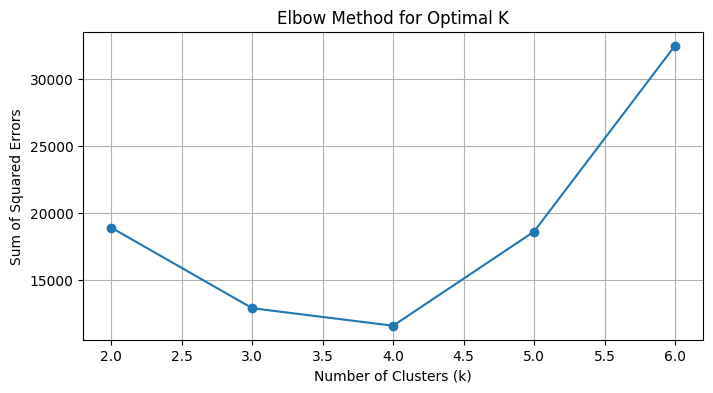

In [55]:
# --- Running My BFR Algorithm ---
def run_experiment(k_val):
    bfr = BFR_Clustering(k=k_val, dim=X.shape[1], mahalanobis_threshold=3.0)

    # 1. Initialize
    init_sample = X[np.random.choice(len(X), min(2000, len(X)), replace=False)]
    bfr.initialize(init_sample)

    # 2. Process chunks
    bfr_chunk_size = 5000 # Pretending I have limited memory (like in a real big data scenario)
    for i in range(0, len(X), bfr_chunk_size):
        chunk = X[i : i + bfr_chunk_size]
        bfr.process_chunk(chunk)

    # 3. Calculate SSE
    sse = 0
    total_points_in_clusters = 0
    for ds in bfr.discard_set:
        # SSE calculation: Sum of Squares minus (Sum squared / Count)
        # Summing across all the feature dimensions
        if ds.N > 0:
            cluster_sse = np.sum(ds.SUMSQ - (ds.SUM**2 / ds.N))
            sse += cluster_sse
            total_points_in_clusters += ds.N

    print(f"  > K={k_val}: Points in Main Clusters: {total_points_in_clusters}/{len(X)}")
    print(f"  > K={k_val}: Retained Outliers: {len(bfr.retained_set)}")

    return sse, bfr

# Trying out different K values
k_values = [2, 3, 4, 5, 6]
sse_scores = []

print("Running BFR for different K values...")
for k in k_values:
    score, _ = run_experiment(k)
    sse_scores.append(score)
    print(f"K={k}, SSE={score:.2f}\n")

# Plotting the Elbow Method graph
plt.figure(figsize=(8, 4))
plt.plot(k_values, sse_scores, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors')
plt.grid(True)
plt.show()

  > K=4: Points in Main Clusters: 39138/48418
  > K=4: Retained Outliers: 92


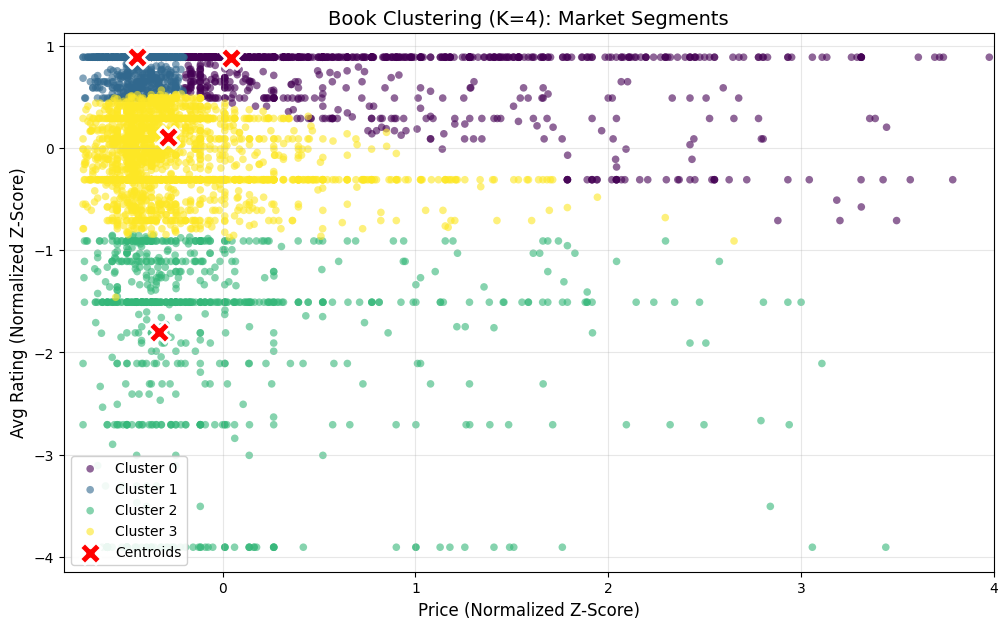


Cluster Interpretation (Denormalized Centroids):
ID  | Price        | Rating     | Count      | Auto-Desc
------------------------------------------------------------
0   | $31.26      | 5.00     | 1          | Expensive
1   | $12.08      | 5.00     | 1          | Cheap Gem
2   | $16.51      | 2.76     | 2          | Poorly Rated
3   | $18.27      | 4.35     | 7          | Popular


In [56]:
# --- Showing Off the Best Clustering Result ---
import matplotlib.cm as cm # Import colormap for dynamic colors

# 1. Setup
best_k = 4 # Can change this K and the plot should still work
_, final_model = run_experiment(best_k)
final_labels = final_model.assign_final_clusters(X)
centroids = np.array([ds.centroid for ds in final_model.discard_set])

# 2. Taking a sample (10% of data) just for plotting, because full data is too much
np.random.seed(42)
sample_indices = np.random.choice(len(X), 5000, replace=False)
sample_X = X[sample_indices]
sample_labels = final_labels[sample_indices]

# 3. Time to plot!
plt.figure(figsize=(12, 7))

# Smart colors: so I get different colors no matter how many clusters (K) I pick
colors = cm.viridis(np.linspace(0, 1, best_k))

# Generic labels, since I can't hardcode them if K changes
# (I'll explain what these clusters mean in the table later)
for i in range(best_k):
    cluster_points = sample_X[sample_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                s=30, alpha=0.6, label=f'Cluster {i}',
                color=colors[i], edgecolors='none')

# Plotting where the cluster centers are
plt.scatter(centroids[:, 0], centroids[:, 1],
           c='red', marker='X', s=250, linewidths=2, edgecolors='white',
           label='Centroids', zorder=10)

# 4. Making the plot zoom in nicely
min_x = np.min(sample_X[:, 0])
plt.xlim(min_x - 0.1, 4.0)

plt.title(f'Book Clustering (K={best_k}): Market Segments', fontsize=14)
plt.xlabel('Price (Normalized Z-Score)', fontsize=12)
plt.ylabel('Avg Rating (Normalized Z-Score)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower left', frameon=True, framealpha=0.9)

plt.show()

# --- 5. Making Sense of the Clusters ---
print("\nCluster Interpretation (Denormalized Centroids):")
print(f"{'ID':<3} | {'Price':<12} | {'Rating':<10} | {'Count':<10} | {'Auto-Desc'}")
print("-" * 60)

for i, center in enumerate(centroids):
    p = (center[0] * stats_summary['Price']['std']) + stats_summary['Price']['mean']
    r = (center[1] * stats_summary['Avg_Rating']['std']) + stats_summary['Avg_Rating']['mean']
    c = (center[2] * stats_summary['Review_Count']['std']) + stats_summary['Review_Count']['mean']

    # Basic guess for what each cluster means
    desc = "Standard"
    if p > 30: desc = "Expensive"
    elif r < 3.0: desc = "Poorly Rated"
    elif c > 5: desc = "Popular"
    elif p < 15 and r > 4.8: desc = "Cheap Gem"

    print(f"{i:<3} | ${p:.2f}{'':<5} | {r:.2f}{'':<4} | {int(c):<10} | {desc}")